<div class="alert alert-block alert-info">
    <h1>Natural Language Processing</h1>
    <h3>General Information:</h3>
    <p>Please do not add or delete any cells. Answers belong into the corresponding cells (below the question). If a function is given (either as a signature or a full function), you should not change the name, arguments or return value of the function.<br><br> If you encounter empty cells underneath the answer that can not be edited, please ignore them, they are for testing purposes.<br><br>When editing an assignment there can be the case that there are variables in the kernel. To make sure your assignment works, please restart the kernel and run all cells before submitting (e.g. via <i>Kernel -> Restart & Run All</i>).</p>
    <p>Code cells where you are supposed to give your answer often include the line  ```raise NotImplementedError```. This makes it easier to automatically grade answers. If you edit the cell please outcomment or delete this line.</p>
    <h3>Submission:</h3>
    <p>Please submit your notebook via the web interface (in the main view -> Assignments -> Submit). The assignments are due on <b>Monday at 15:00</b></p>
    <h3>Group Work:</h3>
    <p>You are allowed to work in groups of up to three people. Please enter the UID (your username here) of each member of the group into the next cell. We apply plagiarism checking, so do not submit solutions from other people except your team members. If an assignment has a copied solution, the task will be graded with 0 points for all people with the same solution.</p>
    <h3>Questions about the Assignment:</h3>
    <p>If you have questions about the assignment please post them in the LEA forum before the deadline. Don't wait until the last day to post questions.</p>
    
</div>

In [ ]:
'''
Group Work:
Enter the UID of each team member into the variables. 
If you work alone please leave the other variables empty.
'''
member1 = 'hvu2s'
member2 = 'anuhel2s'
member3 = 'ksheka2s'


# Word Embeddings

In this assignment we want to create word embeddings (vectors) from a corpus and use them to build a simple document classifier.

For this we will use a subset of the Yelp restaurant dataset. 

The dataset contains a list of reviews, where each review is a dictionary with the following fields:

- ```id```: An integer denoting the id of the review
- ```text```: The original review as a single string
- ```stars```: How the place was rated from 1 (worst) to 5 (best)
- ```tokens```: The tokenized and cleaned review. All tokens have been converted to lower case.

There are two datasets, ```reviews_train``` consisting of 400 reviews (80 per rating) and ```reviews_test``` consisting of 100 reviews (20 per rating).

The following cell shows how to load the datasets into the variables ```train``` and ```test```.


**Attention: This assignment might look like a lot of tasks but you will be able to reuse a lot of answers from the One Hot Embedding tasks for the TfIdf Embedding task**

In [51]:
import pickle

with open('/srv/shares/NLP/datasets/yelp/reviews_train.pkl', 'rb') as f:
    train = pickle.load(f)
    
with open('/srv/shares/NLP/datasets/yelp/reviews_test.pkl', 'rb') as f:
    test = pickle.load(f)
    
# Print a review
train[358]

{'id': 438,
 'text': "Absolutely ridiculously amazing! Chicken Tikka masala was perfect. Best I've ever had!",
 'tokens': ['absolutely',
  'ridiculously',
  'amazing',
  'chicken',
  'tikka',
  'masala',
  'was',
  'perfect',
  'best',
  'i',
  'ever',
  'had'],
 'stars': 5}

In [52]:
from collections import Counter

Counter([review["stars"] for review in test])

Counter({1: 20, 2: 20, 3: 20, 4: 20, 5: 20})

## One Hot Encoding

Perhabs the simplest way to build word embeddings is by using one hot vectors. These are vectors with a length of $|V|$ where $V$ is our vocabulary (the types from our corpus). **The vocabulary should be an alphabetically sorted list of types.**

A one hot vector consists of mostly zeros with a single one at the index of the word in the vocabulary. 

*Example:*

Assume we have the vocabulary ```['a', 'dog', 'i', 'have']```. Then the embedding for the word ```a``` would be $[1, 0, 0, 0]$. The embedding for the word ```i``` would be $[0, 0, 1, 0]$.

### One Hot Encoding A) [15 points]

Complete the class ```OneHotModel```.

This class has the following three methods:

- ```build_index```: Takes a list of documents (each being a list of tokens). Then it creates the dictionary ```self.index``` which maps each type to an index. In the example above the dictionary would look like this:
```self.index = {'a': 0, 'dog': 1, 'i': 2, 'have': 3}``` **It should be sorted alphabetically!**

- ```train```: Takes a list of documents (each being a list of tokens). This should train the one hot model such that it can return vectors for each type in the corpus

- ```embed```: Take a single word and return a one hot encoded vector for that word. If the word is not in the index it should return ```None```


Please complete the three methods of the class.

In [53]:
from typing import List
from abc import ABC, abstractmethod

import numpy as np

# Abstract super class for all embedding models we build, do not edit this
class EmbeddingModel(ABC):
    
    @abstractmethod
    def train(self, docs: List[List[str]]) -> None:
        pass
    
    @abstractmethod
    def embed(self, word: str) -> np.ndarray:
        pass
    
    @abstractmethod
    def vector_size(self) -> int:
        pass


class OneHotModel(EmbeddingModel):
    
    def build_index(self, docs: List[List[str]]) -> None:
        '''
        Create an index for the vocabulary from the docs
        The index should be alphabetically sorted!
        
        Args:
            docs -- A list of documents where each document is a list of tokens
        '''
        self.index = dict()
        words = set(word for sublist in docs for word in sublist)
        sorted_words = sorted(words)
        self.index = {word: idx for idx, word in enumerate(sorted_words)}
    
    def train(self, docs: List[List[str]]) -> None:
        '''
        Train our model with a list of documents
        In the case of one hot encoding training is just building the index!
        
        Args:
            docs -- A list of documents where each document is a list of tokens
        '''
        self.build_index(docs)
    
    def embed(self, word: str) -> np.ndarray:
        '''
        Embed a word into our one hot vector space
        If the word is not in the index it will return None
        
        Args:
            word      -- The word we want an embedding for
        Returns:
            embedding -- The one hot encoded vector for the word
        '''
        if word not in self.index:
            return None
        else:
            one_hot = np.zeros(len(self.index))
            one_hot[self.index[word]] = 1
            return one_hot
            
        
    def vector_size(self) -> int:
        '''
        Return the length of the embedding
        '''
        return len(self.index)

In [54]:
# This is a test cell, please ignore it

### One Hot Encoding B) [10 points]

We now want to use our model to create one hot vectors for each type in our training dataset ```train```.

After training we want to create document embeddings using the bag-of-words approach. For this you need to complete a function called ```bagOfWords``` which takes in a document as a list of strings and our one hot model, maps each token of the document to a one hot vector and sums them up. 

The document embedding is then the sum of all word embeddings in the document **divided by the number of tokens in the document that are <u>present</u> in our model.**

In [79]:
def bagOfWords(model: EmbeddingModel, doc: List[str]) -> np.ndarray:
    '''
    Create a document embedding using the bag of words approach
    
    Args:
        model     -- The embedding model to use
        doc       -- A document as a list of tokens
        
    Returns:
        embedding -- The embedding for the document as a single vector 
    '''
    # If model is tfidf
    if hasattr(model, 'tfidf_matrix'):
        embedding = np.zeros(len(model.tfidf_matrix))
    else: # else One Hot
        embedding = np.zeros(len(model.index))
        
    present_token_in_doc = 0
    for token in doc:
        token_embedding = model.embed(token)
        if token_embedding is not None:
            embedding += token_embedding
            present_token_in_doc += 1
            
    if present_token_in_doc > 0:
        embedding /= present_token_in_doc
    return embedding


# Create a one hot model and train it on a dummy corpus
model = OneHotModel()
corpus = [['i', 'like', 'pizza'],
          ['do', 'you', 'like', 'pizza'],
          ['everybody', 'likes', 'pizza', 'or', 'fries']]

# Train the model on the corpus
model.train(corpus)

# Create a document embedding for the sample document
doc = ['you', 'like', 'many', 'fries', 'fries']

# This should create the embedding: [0, 0, 0.5, 0, 0.25, 0, 0, 0, 0.25]
bagOfWords(model, doc)

array([0.  , 0.  , 0.5 , 0.  , 0.25, 0.  , 0.  , 0.  , 0.25])

In [56]:
# This is a test cell, please ignore it

### One Hot Encoding C) [10 points]

Train your OneHotModel on the reviews from the training set.

Then create the following matrices / vectors from the training and test dataset:

- ```embed_train```: A 2-dimensional numpy array where the rows are the document embeddings for each document in the training set
- ```labels_train```: A 1-dimensional numpy array where each element is the rating (stars) of the review from the training set. The rating at position 3 should correspond to the third row of the ```embed_train``` matrix.
- ```embed_test```: A 2-dimensional numpy array where the rows are the document embeddings for each document in the test set
- ```labels_test```: A 1-dimensional numpy array where each element is the rating (stars) of the review from the test set. The rating at position 3 should correspond to the third row of the ```embed_test``` matrix.

In [86]:
model = OneHotModel()
model.train([review['tokens'] for review in train])

embed_train = np.array([[]])
labels_train = np.array([])

embed_test = np.array([[]])
labels_test = np.array([])

embed_train = np.array([bagOfWords(model, review['tokens']) for review in train])
labels_train = np.array([review['stars'] for review in train])

embed_test = np.array([bagOfWords(model, review['tokens']) for review in test])
labels_test = np.array([review['stars'] for review in test])

print(embed_train.shape)  # Should print (400, 5497)
print(labels_train.shape) # Should print (400, )
print(embed_test.shape)   # Should print (100, 5497)
print(labels_test.shape)  # Should print (100, )

(400, 5497)
(400,)
(100, 5497)
(100,)


In [38]:
print(embed_train[0])

[0.         0.         0.01886792 ... 0.         0.         0.        ]


### One Hot Encoding D) [10 points]

With the matrices and vectors we just created we can train a simple classifier such as a Support Vector Machine for multi-class classification. 

For this we will use an implementation from sklearn ```sklearn.svm.SVC```. Each model from sklearn has two main methods:

- ```fit```: Takes in a matrix like our ```embed_train``` matrix and a vector like our ```labels_train``` vector and trains the classifier on the data

- ```predict```: Takes in a single data vector (like our document vectors) and predicts the label

A nice way of presenting the performance of a classifier is to use a confusion matrix. This is a matrix where the rows show the correct label and columns the predicted label. A perfect classifier would have all samples on the main diagonal and all zeros else.

Luckily ```sklearn``` already provides us with a function to plot a confusion matrix ```sklearn.metrics.plot_confusion_matrix```. This takes in a trained classifier, a matrix of samples and a vector of true labels.

Your task is now to:

- Train the SVM Classifier (SVC) on your training data with standard parameters
- Plot a confusion matrix for the training set
- Plot a confusion matrix for the test set
- Add a title to each confusion matrix

Bonus Task:

Calculate the f1_score using the 'micro' average. [2 points]

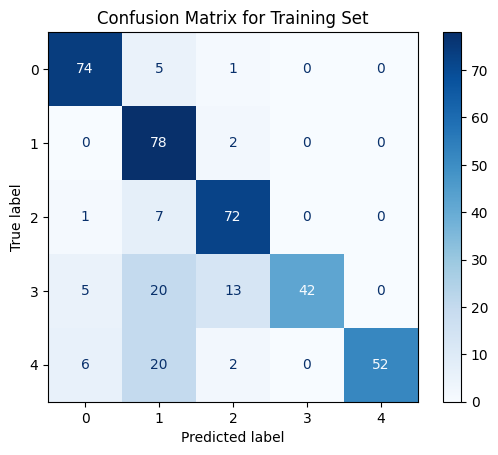

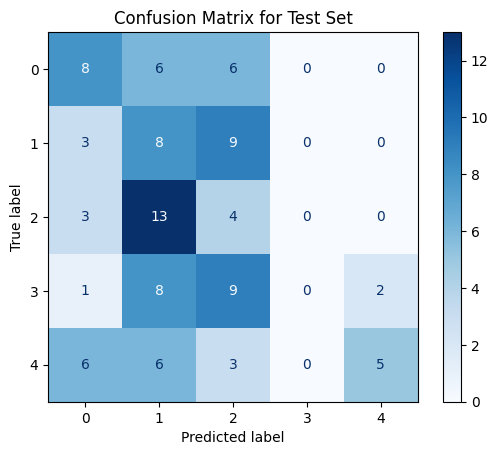

CPU times: user 2.71 s, sys: 279 ms, total: 2.99 s
Wall time: 2.46 s


In [87]:
%%time
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

classifier = SVC(kernel='poly')

classifier.fit(embed_train, labels_train)
train_predictions = classifier.predict(embed_train)
test_predictions = classifier.predict(embed_test)


train_conf_matrix = confusion_matrix(labels_train, train_predictions)
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix)
train_disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Training Set')
plt.show()

test_conf_matrix = confusion_matrix(labels_test, test_predictions)  
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix)
test_disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Test Set')
plt.show()

### One Hot Encoding E) [5 points]

Discuss the performance of your classifier and reason why the performance is the way it is.

The accuracy on training data is pretty above average, more correct predictions than mislabeling. The performace on test data is weak still.

## TfIdf Encoding

Another way of creating word embeddings is to use tfidf embeddings.

For this we need a set of documents from which we create a tfidf matrix. The rows of the matrix correspond to the terms while the columns correspond to the documents (see Figure 6.8 in the chapter *Vector Semantics and Embeddings*). The embedding for a certain word is then the row corresponding to that word in the tfidf matrix.

We use the following equations to calculate the tfidf values:  

$\mathrm{tfidf}(t, d) = \mathrm{tf}(t, d) * \mathrm{idf}(t, d)$  
$\mathrm{tf}(t, d) = \mathrm{log}_{10}(\mathrm{count}(t, d) + 1)$  
$\mathrm{idf}(t, d) = \mathrm{log}_{10}\frac{N}{\mathrm{df}(t)}$  
$\mathrm{df}(t) = $ number of documents $t$ appears in

*Rough outline of the algorithm to create a tfidf matrix*:

1. Start by building a term document matrix $TD$. Each entry in the matrix tells us how often a term $t$ appears in the document $d$. The rows are the documents, the columns are the terms.
2. Apply the logarithm to the $TD$ matrix to create the $TD_{log}$ matrix of logarithmic counts: $TD_{log} = \mathrm{log}_{10}(TD + 1)$.
3. Create a df vector $\vec{\mathrm{df}}$ from that matrix by counting the non zero elements in each column of the TF matrix (`np.count_nonzero`). This tells in how many documents each term appears.
4. Create an idf vector $\vec{\mathrm{idf}}$ from the $\vec{\mathrm{df}}$ by applying the logarithm: $\vec{\mathrm{idf}} = \mathrm{log}_{10}\frac{N}{\vec{\mathrm{df}}}$
5. Multiply each row of $TD_{log}$ by the idf value for that term.

### Example

Corpus:

`document_0 = ["i", "have", "dog", "i", "dog", "dog"]`  
`document_1 = ["a", "cat", "a", "cat"]`  
`document_2 = ["have", "cat", "dog"]`

Index:

| **term**  | a | cat  | dog | have | i |
|-----------|---|------|---|-----|-----|
| **index** | 0 | 1    | 2 | 3   | 4   |

Term document matrix $TD$ matrix:

|      | a   | cat | dog | have | i   |
|------|-----|-----|-----|------|-----|
| doc_0| 0   | 0   | 3   | 1    | 2   |
| doc_1| 2   | 2   | 0   | 0    | 0   |
| doc_2| 0   | 1   | 1   | 1    | 0   |


$TD_{log}$ matrix (rounded to 2 decimals):


|      | a   | cat | dog | have | i   |
|------|-----|-----|-----|------|-----|
| doc_0| 0.00| 0.00| 0.60| 0.30 | 0.48|
| doc_1| 0.48| 0.48| 0.00| 0.00 | 0.00|
| doc_2| 0.00| 0.30| 0.30| 0.30 | 0.00|



Document frequency $\vec{\mathrm{df}}$ :

|      | a   | cat | dog | have | i   |
|------|-----|-----|-----|------|-----|
| doc_0| 0.00| 0.00| 0.60| 0.30 | 0.48|
| doc_1| 0.48| 0.48| 0.00| 0.00 | 0.00|
| doc_2| 0.00| 0.30| 0.30| 0.30 | 0.00|
| | | | | | |
| df   | 1   | 2   | 2   | 2    | 1   |

Inverse document frequency $\vec{\mathrm{idf}}$:

|      | a   | cat | dog | have | i   |
|------|-----|-----|-----|------|-----|
| df   | 1   | 2   | 2   | 2    | 1   |
| idf  | 0.48| 0.18| 0.18| 0.18 | 0.48|


$TFIDF$ matrix:

|      | a   | cat | dog | have | i   |
|------|-----|-----|-----|------|-----|
| doc_0| 0.00| 0.00| 0.11| 0.05 | 0.23|
| doc_1| 0.23| 0.08| 0.00| 0.00 | 0.00|
| doc_2| 0.00| 0.05| 0.05| 0.05 | 0.00|


© Tim Metzler, Hochschule Bonn-Rhein-Sieg

### TfIdf Encoding A) [30 points]

Complete the class ```TfIdfModel```.

This class has the following three methods:

- ```build_index```: Takes a list of documents (each being a list of tokens). Then it creates the dictionary ```self.index``` which maps each type to an index. In the example above the dictionary would look like this:
```self.index = {'a': 0, 'dog': 1, 'i': 2, 'have': 3}```. You can copy your code from the OneHotModel for this function.

- ```train```: Takes a list of documents (each being a list of tokens). This should train the tfidf model such that it can return vectors for each type in the corpus

- ```embed```: Take a single word and return a tfidf vector for that word. If the word is not in the index it should return ```None```


Please complete the three methods of the class.

In [74]:
from typing import List
from collections import Counter
import numpy as np

class TfIdfModel(EmbeddingModel):
    
    def build_index(self, docs: List[List[str]]) -> None:
        '''
        Create an index for the vocabulary from the docs
        
        Args:
            docs -- A list of documents where each document is a list of tokens
        '''
        self.index = dict()
        words = set(word for sublist in docs for word in sublist)
        sorted_words = sorted(words)
        self.index = {word: idx for idx, word in enumerate(sorted_words)}
        
    
    def train(self, docs: List[List[str]]) -> None:
        '''
        Train our model with a list of documents
        
        Args:
            docs -- A list of documents where each document is a list of tokens
        '''
        
        self.build_index(docs)
        # Create an empty tfidf matrix
        self.tfidf_matrix = np.zeros((len(docs), len(self.index)))
        # Create an empty term document matrix
        term_doc_matrix = np.zeros((len(docs), len(self.index)))
        # Create an empty df vector
        df_vector = np.zeros(len(self.index))
        
        # Fill the matrix and compute the tfidf matrix
        num_docs = len(docs)
        for doc_idx, doc in enumerate(docs):
            seen_in_doc = set()
            for word in doc:
                if word in self.index:
                    word_idx = self.index[word]
                    term_doc_matrix[doc_idx, word_idx] += 1
                    if word_idx not in seen_in_doc:
                        df_vector[word_idx] += 1
                        seen_in_doc.add(word_idx)
        term_doc_matrix = np.log10(term_doc_matrix +1)
                    
        for doc_idx in range(num_docs):
            for word_idx in range(len(self.index)):
                tf = term_doc_matrix[doc_idx, word_idx]
                df = df_vector[word_idx]
                idf = np.log10((num_docs) / (df))
                self.tfidf_matrix[doc_idx, word_idx] = tf * idf
                    
        
    def embed(self, word: str) -> np.ndarray:
        '''
        Embed a word into our tfidf vector space
        If the word is not in the index it will return None
        
        Args:
            word      -- The word we want an embedding for
        Returns:
            embedding -- The tfidf embedding for the word
        '''
        if word not in self.index:
            return None
        else:
            word_idx= self.index[word]
            return self.tfidf_matrix[:, word_idx]
        
    def vector_size(self) -> int:
        return self.tfidf_matrix.shape[0]

In [80]:
# Here you can verify the working of your tfidf model

# Create a tfidf model and train it on a dummy corpus
model = TfIdfModel()
corpus = [
    ["i", "have", "dog", "i", "dog", "dog"],
    ["a", "cat", "a", "cat"],
    ["have", "cat", "dog"]
]

# Train the model on the corpus
model.train(corpus)

'''Show the index of the model
Should be: 
{'a': 0, 'cat': 1, 'dog': 2, 'have': 3, 'i': 4} -> Alphabetically sorted!
'''
print('The index of your model is:')
print(model.index)

# Create a document embedding for the sample document
doc = ['i', 'have', 'a', 'cool', 'dog']

# This should create the embedding: ([0.09666774 0.05691117 0.02650438])
print(f'The document embedding for {doc} is:')
print(bagOfWords(model, doc))
print()

# Show the internal tfidf matrix for this corpus:
'''
Expected is:
[[0.         0.         0.1060175  0.05300875 0.22764469]
 [0.22764469 0.08401688 0.         0.         0.        ]
 [0.         0.05300875 0.05300875 0.05300875 0.        ]]
'''

print('Tfidf matrix of your model:\n', model.tfidf_matrix)

print(model.embed("have"))

The index of your model is:
{'a': 0, 'cat': 1, 'dog': 2, 'have': 3, 'i': 4}
The document embedding for ['i', 'have', 'a', 'cool', 'dog'] is:
[0.09666774 0.05691117 0.02650438]

Tfidf matrix of your model:
 [[0.         0.         0.1060175  0.05300875 0.22764469]
 [0.22764469 0.08401688 0.         0.         0.        ]
 [0.         0.05300875 0.05300875 0.05300875 0.        ]]
[0.05300875 0.         0.05300875]


### TfIdf Encoding B) [5 points]

To build tfidf document vectors we can use the same approach as for the one hot document vectors.

Train your TfIdfModel on the reviews from the training set.

Then create the following matrices / vectors from the training and test dataset:

- ```embed_train```: A 2-dimensional numpy array where the rows are the document embeddings for each document in the training set
- ```labels_train```: A 1-dimensional numpy array where each element is the rating (stars) of the review from the training set. The rating at position 3 should correspond to the third row of the ```embed_train``` matrix.
- ```embed_test```: A 2-dimensional numpy array where the rows are the document embeddings for each document in the test set
- ```labels_test```: A 1-dimensional numpy array where each element is the rating (stars) of the review from the test set. The rating at position 3 should correspond to the third row of the ```embed_test``` matrix.

In [88]:
model = TfIdfModel()
model.train([review['tokens'] for review in train])

embed_train = np.array([[]])
labels_train = np.array([])

embed_test = np.array([[]])
labels_test = np.array([])

embed_train = np.array([bagOfWords(model, review['tokens']) for review in train])
labels_train = np.array([review['stars'] for review in train])

embed_test = np.array([bagOfWords(model, review['tokens']) for review in test])
labels_test = np.array([review['stars'] for review in test])

print(embed_train.shape)  # Should print (400, 400)
print(labels_train.shape) # Should print (400, )
print(embed_test.shape)   # Should print (100, 400)
print(labels_test.shape)  # Should print (100, )

(400, 400)
(400,)
(100, 400)
(100,)


### TfIdf Encoding C) [5 points]

Similar to task One Hot Encoding D) we want to train a classifier. 

- Train the SVM Classifier (SVC) on your training data with standard parameters
- Plot a confusion matrix for the training set
- Plot a confusion matrix for the test set
- Add a title to each confusion matrix

Bonus Task:

Calculate the f1_score using the 'micro' average. [2 points]

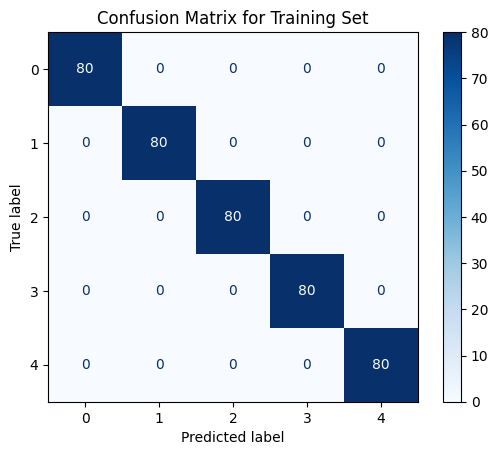

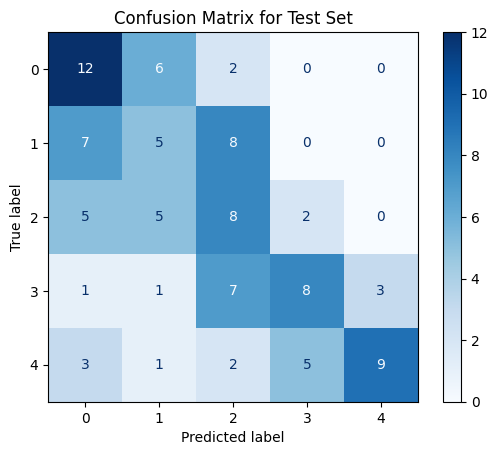

CPU times: user 867 ms, sys: 333 ms, total: 1.2 s
Wall time: 675 ms


In [89]:
%%time
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

classifier = SVC(kernel='poly')

classifier.fit(embed_train, labels_train)
train_predictions = classifier.predict(embed_train)
test_predictions = classifier.predict(embed_test)


train_conf_matrix = confusion_matrix(labels_train, train_predictions)
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix)
train_disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Training Set')
plt.show()

test_conf_matrix = confusion_matrix(labels_test, test_predictions)  
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix)
test_disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Test Set')
plt.show()


### TfIdf Encoding D) [10 points]

Discuss the performance of the TfIdf Embeddings for this task compared to the performance of the One Hot Embeddings. Which one is better? Why?

Performance-wise, TfIdf is way better than One Hot Embedding. Predictions are all correct on training data after training. On test data there are some wrong prediction but overall still better